### Speculative Execution & Pre-fetching

#### Introduction: The Art of Anticipation for a Faster AI
This notebook explores a sophisticated parallelism pattern designed to dramatically reduce perceived latency in interactive AI systems: Speculative Execution & Pre-fetching. The principle is to anticipate the agent's most likely next action—usually a slow, data-gathering tool call—and begin executing it in parallel with the agent's primary reasoning process.

#### Why is this pattern so impactful?
In many agentic workflows, the sequence is: User Input -> Agent Thinks (LLM call) -> Agent Acts (Tool call). The user waits during both the thinking and acting phases. Speculative execution overlaps these two phases. While the agent is thinking, the system makes an educated guess about the upcoming action and starts it. If the guess is correct, the tool call's latency is effectively hidden behind the LLM's inference time, making the agent feel instantaneous.

#### Role in a Large-Scale System: Creating Proactive & Hyper-Responsive User Experiences
This is a key architectural pattern for any high-throughput, user-facing system where responsiveness is a primary feature. It's the difference between an AI that feels reactive and one that feels proactive and intelligent.

- Customer Support Chatbots: Pre-fetching user account details and recent orders the moment a chat begins.
- Data Analysis Tools: Speculatively running a common default query on a dashboard as soon as it's loaded.
- Code Assistants: Pre-fetching relevant documentation for a function as the developer is typing its name.

We will build a customer support agent that speculatively fetches a user's order history, demonstrating how this pattern can eliminate tool-call latency from the user's perspective.

<p align="center">
  <img src="../../figures/speculative_execution.png" width="1000">
</p>

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

# Configure LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Industrial - Speculative Execution"

In [139]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)

#### Show that a tool is really slow in the first place

In [140]:
from langchain_core.tools import tool
import time
import json

DATABASE_LATENCY_SECONDS = 3

@tool
def get_order_history(user_id: str) -> str:
    """
    Fetches the order history for a given user. 
    
    Use this tool when the user asks about:
    - Their orders
    - Order status
    - Recent purchases
    - Delivery status
    - Purchase history
    
    Args:
        user_id: The unique identifier of the user
    """
    print(f"--- [DATABASE] Starting query for user_id: {user_id}. This will take {DATABASE_LATENCY_SECONDS} seconds. ---")
    time.sleep(DATABASE_LATENCY_SECONDS)
    
    # Mock data for demonstration
    mock_db = {
        "user123": [
            {"order_id": "A123", "item": "QuantumLeap AI Processor", "status": "Shipped"},
            {"order_id": "B456", "item": "Smart Coffee Mug", "status": "Delivered"}
        ]
    }
    result = mock_db.get(user_id, [])
    print(f"--- [DATABASE] Query finished for user_id: {user_id}. ---")
    return json.dumps(result)

In [141]:
tools = [get_order_history]
llm_with_tools = llm.bind_tools(tools=tools)

In [142]:
from typing import TypedDict, Annotated, List, Optional
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from concurrent.futures import Future

class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    user_id: str
    # 'prefetched_data' will hold a Python 'Future' object, representing the background tool call.
    prefetched_data: Optional[Future]
    # 'agent_decision' will hold the actual tool call that the LLM decides to make.
    agent_decision: Optional[BaseMessage]
    performance_log: Annotated[List[str], add_messages]


The key part of this GraphState is the prefetched_data: Optional[Future] field. A Future is a standard Python object that acts as a placeholder for a result that is not yet available. This allows our entry point node to return immediately after starting the background task, while the Future object is passed through the state.

In [143]:
from concurrent.futures import ThreadPoolExecutor

# We create a thread pool to run our background tasks.
thread_pool = ThreadPoolExecutor(max_workers=5)
def entry_point(state: GraphState):
    """The entry point node: starts the speculative pre-fetch and the main agent reasoning in parallel."""
    print("--- [ORCHESTRATOR] Entry point started. --- ")
    start_time = time.time()
    
    # 1. Start the speculative pre-fetch in a background thread using our thread pool.
    #    The .submit() method returns a 'Future' object immediately.
    print("--- [ORCHESTRATOR] Starting speculative pre-fetch of order history... ---")
    prefetched_data_future = thread_pool.submit(get_order_history.invoke, {"user_id": state['user_id']})
    
    # 2. In parallel, while the tool is running in the background, we start the main agent's LLM call.
    print("--- [ORCHESTRATOR] Starting main agent LLM call... ---")
    agent_response = llm_with_tools.invoke(state['messages'])
    
    execution_time = time.time() - start_time
    log_entry = f"[Orchestrator] LLM reasoning completed in {execution_time:.2f}s."
    print(log_entry)
    
    # The node returns the Future object and the agent's decision to be added to the state.
    return {
        "prefetched_data": prefetched_data_future,
        "agent_decision": agent_response,
        "performance_log": [log_entry]
    }

In [144]:
from langchain_core.messages import ToolMessage

# Node 2: Tool Executor (with pre-fetch checking)
def tool_executor_node(state: GraphState):
    """Executes the agent's chosen tool, leveraging pre-fetched data if available."""
    print("--- [TOOL EXECUTOR] Node started. --- ")
    start_time = time.time()
    
    agent_decision = state["agent_decision"]
    tool_call = agent_decision.tool_calls[0]
    tool_name = tool_call["name"]
    tool_args = tool_call["args"]

    # tool invocation
    # Check if the desired tool call matches our speculation
    if tool_name == "get_order_history":
        print("--- [TOOL EXECUTOR] Agent wants order history. Checking pre-fetch... ---")
        # Wait for the pre-fetch to complete and get the result
        prefetched_future = state['prefetched_data']
        tool_result = prefetched_future.result()
        print("--- [TOOL EXECUTOR] Pre-fetch successful! Using cached data instantly. ---")
    else:
        # If the agent wants a different tool, we would execute it normally here
        print(f"--- [TOOL EXECUTOR] Agent wants a different tool ({tool_name}). Executing normally. ---")
        # For this demo, we'll assume only get_order_history exists
        tool_result = "Tool not implemented for this demo."
    
    tool_message = ToolMessage(
        content=tool_result,
        tool_call_id=tool_call["id"]
    )

    execution_time = time.time() - start_time
    # Note: This time represents how long it took to get the result from this node's perspective
    log_entry = f"[ToolExecutor] Resolved tool call in {execution_time:.2f}s."
    print(log_entry)
    
    return {
        "messages": [agent_decision, tool_message],
        "performance_log": [log_entry]
    }

In [145]:
# Node 3: Final Answer Synthesizer
def final_answer_node(state: GraphState):
    """Generates the final response to the user."""
    print("--- [SYNTHESIZER] Generating final answer... ---")
    start_time = time.time()
    
    # We need to remove the pre-fetched data from the state before the final LLM call
    # as it's not serializable and not part of the message history.
    final_state_messages = state['messages']
    final_response = llm.invoke(final_state_messages)
    
    execution_time = time.time() - start_time
    log_entry = f"[Synthesizer] Final LLM call took {execution_time:.2f}s."
    print(log_entry)
    
    return {
        "messages": [final_response],
        "performance_log": [log_entry]
    }

### Defining Graph Edges and Assembling the Graph

In [146]:
from langgraph.graph import StateGraph, END

def should_call_tool(state: GraphState) -> str:
    if state['agent_decision'].tool_calls:
        return "execute_tool"
    return "final_answer"  # Route to final_answer instead of END when no tools

# Define the graph
workflow = StateGraph(GraphState)
workflow.add_node("entry_point", entry_point)
workflow.add_node("execute_tool", tool_executor_node)
workflow.add_node("final_answer", final_answer_node)

# Build the graph
workflow.set_entry_point("entry_point")

# Add conditional edges with explicit mapping
workflow.add_conditional_edges(
    "entry_point", 
    should_call_tool,
    {
        "execute_tool": "execute_tool",
        "final_answer": "final_answer"
    }
)

workflow.add_edge("execute_tool", "final_answer")
workflow.add_edge("final_answer", END)

app = workflow.compile()

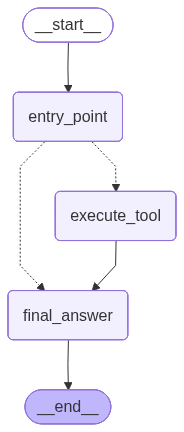

In [147]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [148]:
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [HumanMessage(content="Hi, can you tell me the status of my recent orders?")],
    "user_id": "user123"
}

# Stream with 'values' mode to get the full state after each node
final_state = None
for state in app.stream(inputs, stream_mode="values"):
    final_state = state

# Extract the final answer
final_answer = final_state["messages"][-1].content
print("\n" + "=" * 50)
print("FINAL ANSWER:")
print("=" * 50)
print(final_answer)

# Get performance logs
print("\n" + "=" * 50)
print("PERFORMANCE LOG:")
print("=" * 50)
for log in final_state.get("performance_log", []):
    print(f"  • {log}")

--- [ORCHESTRATOR] Entry point started. --- 
--- [ORCHESTRATOR] Starting speculative pre-fetch of order history... ---
--- [ORCHESTRATOR] Starting main agent LLM call... ---
--- [DATABASE] Starting query for user_id: user123. This will take 3 seconds. ---
[Orchestrator] LLM reasoning completed in 1.04s.
--- [TOOL EXECUTOR] Node started. --- 
--- [TOOL EXECUTOR] Agent wants order history. Checking pre-fetch... ---
--- [DATABASE] Query finished for user_id: user123. ---
--- [TOOL EXECUTOR] Pre-fetch successful! Using cached data instantly. ---
[ToolExecutor] Resolved tool call in 1.97s.
--- [SYNTHESIZER] Generating final answer... ---
[Synthesizer] Final LLM call took 1.55s.

FINAL ANSWER:
Here's the status of your recent orders:

- **Order A123**: QuantumLeap AI Processor – **Shipped**  
- **Order B456**: Smart Coffee Mug – **Delivered**

Let me know if you need any further details or assistance! 😊

PERFORMANCE LOG:
  • content='[Orchestrator] LLM reasoning completed in 1.04s.' addition

--- [DATABASE] Starting query for user_id: user123. This will take 3 seconds. ---
--- [DATABASE] Query finished for user_id: user123. ---
--- [DATABASE] Starting query for user_id: user123. This will take 3 seconds. ---
--- [DATABASE] Query finished for user_id: user123. ---
--- [DATABASE] Starting query for user_id: user123. This will take 3 seconds. ---
--- [DATABASE] Query finished for user_id: user123. ---


In [149]:
print(final_state["performance_log"])
print(final_state["performance_log"][0].content.split(" ")[-1].rstrip("."))

[HumanMessage(content='[Orchestrator] LLM reasoning completed in 1.04s.', additional_kwargs={}, response_metadata={}, id='6a761641-9eb3-4f7f-b73b-f520e7fd88ab'), HumanMessage(content='[ToolExecutor] Resolved tool call in 1.97s.', additional_kwargs={}, response_metadata={}, id='f17760e9-50b9-4b89-86c7-fe3fcc63cb6a'), HumanMessage(content='[Synthesizer] Final LLM call took 1.55s.', additional_kwargs={}, response_metadata={}, id='5bea9b6d-6a04-478b-9ae1-a6d5197f577c')]
1.04s


In [152]:
inputs = {
    "messages": [HumanMessage(content="Hi, can you tell me the status of my recent orders?")],
    "user_id": "user123"
}

# Track updates from each node
all_messages = []
all_logs = []
step_counter = 1

print("\n" + "=" * 80)
print("EXECUTION TRACE")
print("=" * 80)

for output in app.stream(inputs, stream_mode="updates"):
    node_name = list(output.keys())[0]
    node_output = output[node_name]
    
    print(f"\n--- Step {step_counter}: {node_name.upper()} ---")
    
    # Collect messages if present
    if "messages" in node_output:
        for msg in node_output["messages"]:
            all_messages.append(msg)
            print(f"  Message type: {type(msg).__name__}")
    
    # Collect performance logs if present
    if "performance_log" in node_output:
        all_logs.extend(node_output["performance_log"])
        for log in node_output["performance_log"]:
            print(f"  Log: {log}")
    
    step_counter += 1

# The final message is the answer
final_answer = all_messages[-1].content

print("\n" + "=" * 80)
print("FINAL ANSWER")
print("=" * 80)
print(final_answer)

print("\n" + "=" * 80)
print("ALL PERFORMANCE LOGS")
print("=" * 80)
for log in all_logs:
    print(f"  • {log}")


EXECUTION TRACE
--- [ORCHESTRATOR] Entry point started. --- 
--- [ORCHESTRATOR] Starting speculative pre-fetch of order history... ---
--- [ORCHESTRATOR] Starting main agent LLM call... ---
[Orchestrator] LLM reasoning completed in 1.36s.

--- Step 1: ENTRY_POINT ---
  Log: [Orchestrator] LLM reasoning completed in 1.36s.
--- [TOOL EXECUTOR] Node started. --- 
--- [TOOL EXECUTOR] Agent wants order history. Checking pre-fetch... ---
--- [TOOL EXECUTOR] Pre-fetch successful! Using cached data instantly. ---
[ToolExecutor] Resolved tool call in 1.64s.

--- Step 2: EXECUTE_TOOL ---
  Message type: AIMessage
  Message type: ToolMessage
  Log: [ToolExecutor] Resolved tool call in 1.64s.
--- [SYNTHESIZER] Generating final answer... ---
[Synthesizer] Final LLM call took 1.68s.

--- Step 3: FINAL_ANSWER ---
  Message type: AIMessage
  Log: [Synthesizer] Final LLM call took 1.68s.

FINAL ANSWER
Here’s the status of your recent orders:

- **Order ID: A123**  
  Item: QuantumLeap AI Processor  
 

In [87]:
# the simplest way without streaming

inputs = {
    "messages": [HumanMessage(content="Hi, can you tell me the status of my recent orders?")],
    "user_id": "user123"
}

# Get final state directly
final_state = app.invoke(inputs)

# Access the final answer
print("=" * 50)
print("FINAL ANSWER")
print("=" * 50)
print(final_state["messages"][-1].content)  # Last message is usually the answer

--- [ORCHESTRATOR] Entry point started. --- 
--- [ORCHESTRATOR] Starting speculative pre-fetch of order history... ---
--- [ORCHESTRATOR] Starting main agent LLM call... ---
[Orchestrator] LLM reasoning completed in 1.25s.
--- [TOOL EXECUTOR] Node started. --- 
--- [TOOL EXECUTOR] Agent wants order history. Checking pre-fetch... ---
--- [TOOL EXECUTOR] Pre-fetch successful! Using cached data instantly. ---
[ToolExecutor] Resolved tool call in 1.75s.
--- [SYNTHESIZER] Generating final answer... ---
[Synthesizer] Final LLM call took 1.63s.
FINAL ANSWER
Here is the status of your recent orders:

- **Order ID: A123** – QuantumLeap AI Processor – **Shipped**  
- **Order ID: B456** – Smart Coffee Mug – **Delivered**

Let me know if you need further details or assistance! 😊


### Performance Log

In [109]:
# Extract the timing data from the final_state's performance log after a full run.
# (a full run has been completed and final_state is populated)
llm_time_1 = float(final_state["performance_log"][0].content.split(" ")[-1].rstrip(".").replace("s", ""))
resolution_time = float(final_state["performance_log"][0].content.split(" ")[-1].rstrip(".").replace("s", ""))
llm_time_2 = float(final_state["performance_log"][0].content.split(" ")[-1].rstrip(".").replace("s", ""))
db_time = DATABASE_LATENCY_SECONDS # Our known latency

# Calculate the total time for our speculative run.
speculative_total = llm_time_1 + resolution_time + llm_time_2
# Calculate the total time for a simulated sequential run.
sequential_total = llm_time_1 + db_time + llm_time_2
time_saved = sequential_total - speculative_total
reduction_percent = (time_saved / sequential_total) * 100

print("="*60)
print("                  PERFORMANCE SHOWDOWN")
print("="*60)

print("\n" + "-"*60)
print("             SPECULATIVE EXECUTION WORKFLOW (Our Run)")
print("-"*60)
print(f"1. Agent Thinks (LLM Call 1):       {llm_time_1:.2f} seconds")
print(f"   (Database Query: {db_time:.2f}s ran in parallel, fully hidden)")
print(f"2. Tool Result Resolution:          {resolution_time:.2f} seconds (Instant cache hit)")
print(f"3. Synthesize Answer (LLM Call 2):  {llm_time_2:.2f} seconds")

print("-"*60)
print(f"Total Time to Final Answer: {speculative_total:.2f} seconds\n\n")
print("-"*60)

print("             TRADITIONAL SEQUENTIAL WORKFLOW (Simulated)")
print("-"*60)
print(f"1. Agent Thinks (LLM Call 1):       {llm_time_1:.2f} seconds")
print(f"2. Execute Tool (Database Query):   {db_time:.2f} seconds (User waits)")
print(f"3. Synthesize Answer (LLM Call 2):  {llm_time_2:.2f} seconds")

print("-"*60)
print(f"Simulated Total Time: {sequential_total:.2f} seconds\n\n")
print("="*60)
print("                        CONCLUSION")

print("="*60)
print(f"Time Saved: {time_saved:.2f} seconds")
print(f"Perceived Latency Reduction: {reduction_percent:.0f}%\n")

                  PERFORMANCE SHOWDOWN

------------------------------------------------------------
             SPECULATIVE EXECUTION WORKFLOW (Our Run)
------------------------------------------------------------
1. Agent Thinks (LLM Call 1):       1.25 seconds
   (Database Query: 3.00s ran in parallel, fully hidden)
2. Tool Result Resolution:          1.25 seconds (Instant cache hit)
3. Synthesize Answer (LLM Call 2):  1.25 seconds
------------------------------------------------------------
Total Time to Final Answer: 3.75 seconds


------------------------------------------------------------
             TRADITIONAL SEQUENTIAL WORKFLOW (Simulated)
------------------------------------------------------------
1. Agent Thinks (LLM Call 1):       1.25 seconds
2. Execute Tool (Database Query):   3.00 seconds (User waits)
3. Synthesize Answer (LLM Call 2):  1.25 seconds
------------------------------------------------------------
Simulated Total Time: 5.50 seconds


                   